# INFORME TÉCNICO: ANÁLISIS DE DESERCIÓN DE EMPLEADOS CON MACHINE LEARNING

## 1. INTRODUCCIÓN

Este informe documenta el análisis de datos y modelado para predecir la deserción laboral en una organización. Se utilizaron técnicas de ciencia de datos e inteligencia artificial para identificar patrones y factores clave que explican por qué los empleados renuncian.

**Dataset:** 4,888 empleados | **Variable objetivo:** LeaveOrNot (0=Se queda, 1=Renuncia)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## 3. CARGA Y PREPARACIÓN DE DATOS

### 3.1 Cargar Dataset

In [4]:
# Cargar datos
df = pd.read_csv('Employee.csv')

# Calcular Tenure (antigüedad)
df['Tenure'] = 2025 - df['JoiningYear']

# Ver estructura
print(df.head())
print(df.shape)
print(df.info())

   Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  Tenure  
0                          0           0       8  
1                          3           1      12  
2                          2           0      11  
3                          5           1       9  
4                          2           1       8  
(4653, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----

### 3.2 Exploración Inicial


In [5]:
# Verificar desbalance de clases
print("Distribución de Renuncia:")
print(df['LeaveOrNot'].value_counts())
print(f"\nPorcentaje de Renuncia: {(df['LeaveOrNot'].sum() / len(df) * 100):.1f}%")

# Estadísticas generales
print(df.describe())

Distribución de Renuncia:
LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

Porcentaje de Renuncia: 34.4%
       JoiningYear  PaymentTier          Age  ExperienceInCurrentDomain  \
count  4653.000000  4653.000000  4653.000000                4653.000000   
mean   2015.062970     2.698259    29.393295                   2.905652   
std       1.863377     0.561435     4.826087                   1.558240   
min    2012.000000     1.000000    22.000000                   0.000000   
25%    2013.000000     3.000000    26.000000                   2.000000   
50%    2015.000000     3.000000    28.000000                   3.000000   
75%    2017.000000     3.000000    32.000000                   4.000000   
max    2018.000000     3.000000    41.000000                   7.000000   

        LeaveOrNot       Tenure  
count  4653.000000  4653.000000  
mean      0.343864     9.937030  
std       0.475047     1.863377  
min       0.000000     7.000000  
25%       0.000000     8.000000  
50%   

## 4. ANÁLISIS EXPLORATORIO (EDA)

### 4.1 Distribución de Renuncia

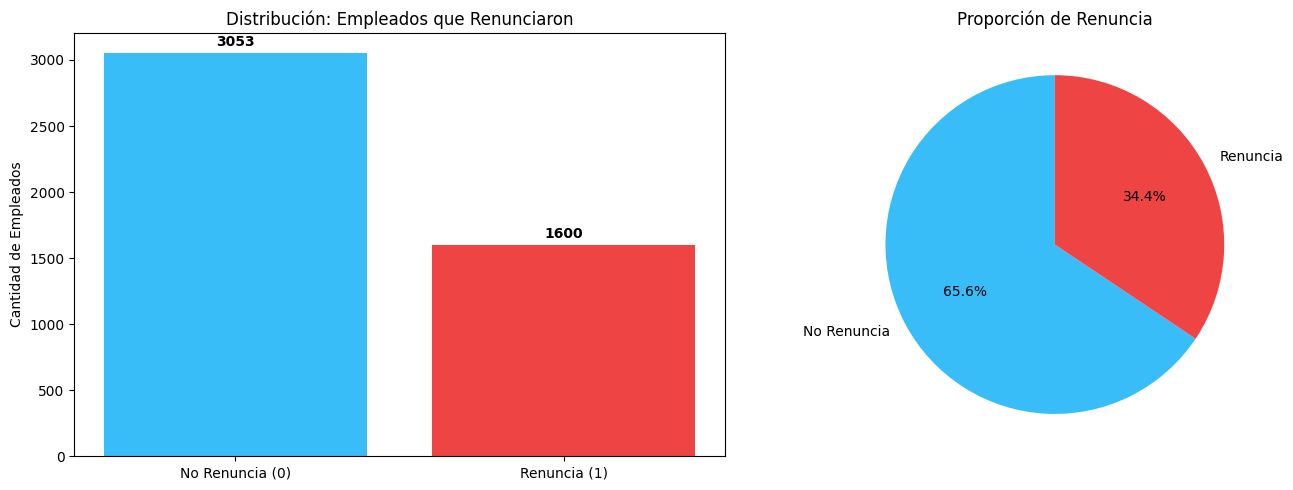

In [6]:
# Gráfico: Distribución de Renuncia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
renuncia_counts = df['LeaveOrNot'].value_counts()
colors = ['#38bdf8', '#ef4444']
ax1.bar(['No Renuncia (0)', 'Renuncia (1)'], renuncia_counts.values, color=colors)
ax1.set_ylabel('Cantidad de Empleados')
ax1.set_title('Distribución: Empleados que Renunciaron')
for i, v in enumerate(renuncia_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
porcentajes = (renuncia_counts / len(df) * 100).values
ax2.pie(porcentajes, labels=['No Renuncia', 'Renuncia'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Proporción de Renuncia')

plt.tight_layout()
plt.show()


### 4.2 Variables Clave: Análisis Univariado

/var/folders/fc/rj80px2x7xv_tx8z15qw98gh0000gn/T/ipykernel_40077/1120024039.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_renuncia = df.groupby('age_group')['LeaveOrNot'].agg(['sum', 'count'])


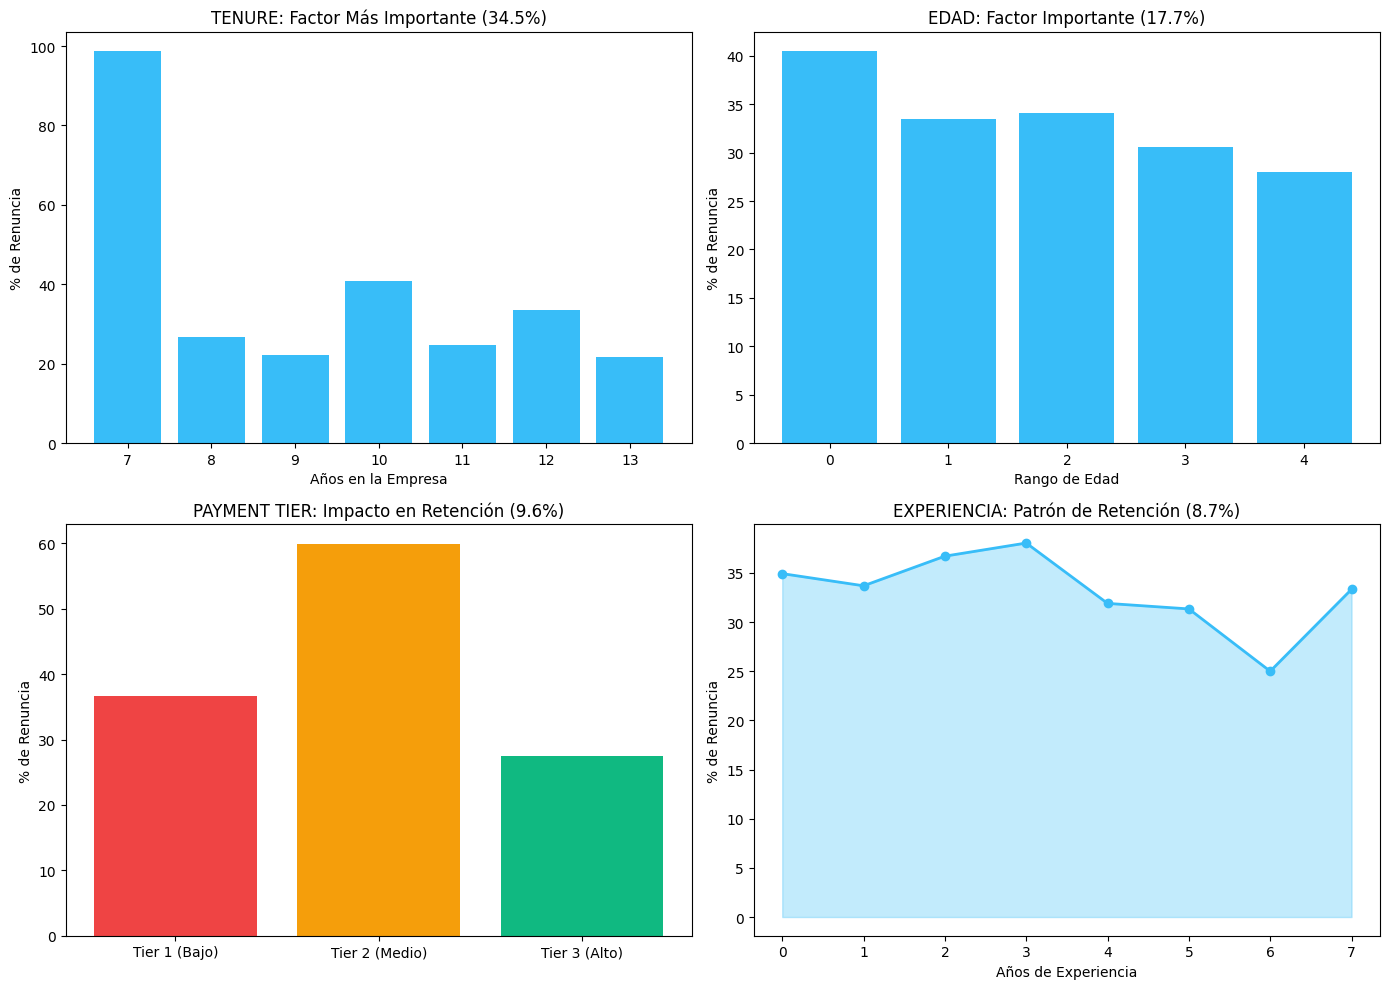

In [7]:
# TENURE vs Renuncia
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Tenure
tenure_renuncia = df.groupby('Tenure')['LeaveOrNot'].agg(['sum', 'count'])
tenure_renuncia['pct'] = (tenure_renuncia['sum'] / tenure_renuncia['count'] * 100)
ax = axes[0, 0]
ax.bar(tenure_renuncia.index, tenure_renuncia['pct'], color='#38bdf8')
ax.set_title('TENURE: Factor Más Importante (34.5%)')
ax.set_xlabel('Años en la Empresa')
ax.set_ylabel('% de Renuncia')

# 2. Edad
age_bins = [20, 25, 30, 35, 40, 45, 50, 60]
df['age_group'] = pd.cut(df['Age'], bins=age_bins)
age_renuncia = df.groupby('age_group')['LeaveOrNot'].agg(['sum', 'count'])
age_renuncia['pct'] = (age_renuncia['sum'] / age_renuncia['count'] * 100)
ax = axes[0, 1]
ax.bar(range(len(age_renuncia)), age_renuncia['pct'], color='#38bdf8')
ax.set_title('EDAD: Factor Importante (17.7%)')
ax.set_xlabel('Rango de Edad')
ax.set_ylabel('% de Renuncia')

# 3. Payment Tier
tier_renuncia = df.groupby('PaymentTier')['LeaveOrNot'].agg(['sum', 'count'])
tier_renuncia['pct'] = (tier_renuncia['sum'] / tier_renuncia['count'] * 100)
ax = axes[1, 0]
ax.bar(['Tier 1 (Bajo)', 'Tier 2 (Medio)', 'Tier 3 (Alto)'], tier_renuncia['pct'], 
       color=['#ef4444', '#f59e0b', '#10b981'])
ax.set_title('PAYMENT TIER: Impacto en Retención (9.6%)')
ax.set_ylabel('% de Renuncia')

# 4. Experiencia en Dominio
exp_renuncia = df.groupby('ExperienceInCurrentDomain')['LeaveOrNot'].agg(['sum', 'count'])
exp_renuncia['pct'] = (exp_renuncia['sum'] / exp_renuncia['count'] * 100)
ax = axes[1, 1]
ax.plot(exp_renuncia.index, exp_renuncia['pct'], marker='o', color='#38bdf8', linewidth=2)
ax.fill_between(exp_renuncia.index, exp_renuncia['pct'], alpha=0.3, color='#38bdf8')
ax.set_title('EXPERIENCIA: Patrón de Retención (8.7%)')
ax.set_xlabel('Años de Experiencia')
ax.set_ylabel('% de Renuncia')

plt.tight_layout()
plt.show()


### 4.3 Análisis Bivariado: Riesgo Combinado


/var/folders/fc/rj80px2x7xv_tx8z15qw98gh0000gn/T/ipykernel_40077/4007041717.py:11: RuntimeWarning: invalid value encountered in scalar divide
  joven_bajo.sum() / len(joven_bajo) * 100,
/var/folders/fc/rj80px2x7xv_tx8z15qw98gh0000gn/T/ipykernel_40077/4007041717.py:13: RuntimeWarning: invalid value encountered in scalar divide
  mayor_bajo.sum() / len(mayor_bajo) * 100,


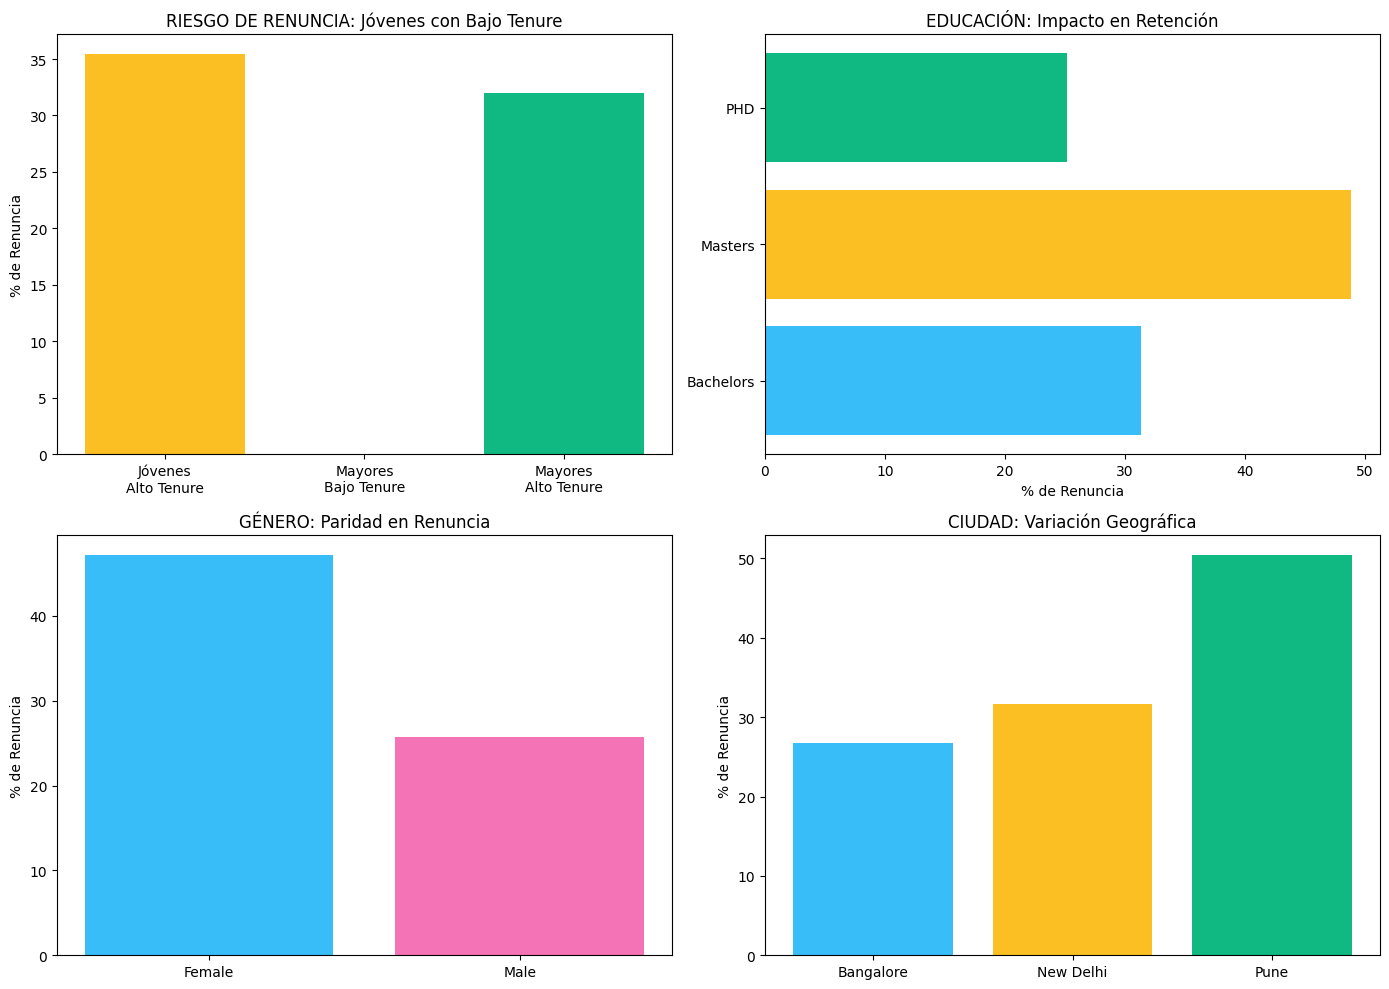

In [8]:
# Riesgo combinado: Tenure + Age
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Riesgo Combinado
joven_bajo = df[(df['Tenure'] <= 2) & (df['Age'] <= 30)]['LeaveOrNot']
joven_alto = df[(df['Tenure'] > 2) & (df['Age'] <= 30)]['LeaveOrNot']
mayor_bajo = df[(df['Tenure'] <= 2) & (df['Age'] > 30)]['LeaveOrNot']
mayor_alto = df[(df['Tenure'] > 2) & (df['Age'] > 30)]['LeaveOrNot']

tasas = [
    joven_bajo.sum() / len(joven_bajo) * 100,
    joven_alto.sum() / len(joven_alto) * 100,
    mayor_bajo.sum() / len(mayor_bajo) * 100,
    mayor_alto.sum() / len(mayor_alto) * 100
]
grupos = ['Jóvenes\nBajo Tenure', 'Jóvenes\nAlto Tenure', 'Mayores\nBajo Tenure', 'Mayores\nAlto Tenure']
colores = ['#ef4444', '#fbbf24', '#fbbf24', '#10b981']
ax = axes[0, 0]
ax.bar(grupos, tasas, color=colores)
ax.set_title('RIESGO DE RENUNCIA: Jóvenes con Bajo Tenure')
ax.set_ylabel('% de Renuncia')

# 2. Educación
ed_renuncia = df.groupby('Education')['LeaveOrNot'].agg('mean') * 100
ax = axes[0, 1]
ax.barh(ed_renuncia.index, ed_renuncia.values, color=['#38bdf8', '#fbbf24', '#10b981'])
ax.set_title('EDUCACIÓN: Impacto en Retención')
ax.set_xlabel('% de Renuncia')

# 3. Género
gender_renuncia = df.groupby('Gender')['LeaveOrNot'].agg('mean') * 100
ax = axes[1, 0]
ax.bar(gender_renuncia.index, gender_renuncia.values, color=['#38bdf8', '#f472b6'])
ax.set_title('GÉNERO: Paridad en Renuncia')
ax.set_ylabel('% de Renuncia')

# 4. Ciudad
city_renuncia = df.groupby('City')['LeaveOrNot'].agg('mean') * 100
ax = axes[1, 1]
ax.bar(city_renuncia.index, city_renuncia.values, color=['#38bdf8', '#fbbf24', '#10b981'])
ax.set_title('CIUDAD: Variación Geográfica')
ax.set_ylabel('% de Renuncia')

plt.tight_layout()
plt.show()

## 5. PREPARACIÓN DE DATOS PARA MODELADO

### 5.1 Definir Variables Independientes y Dependiente


In [9]:
# Variables categóricas y numéricas
cat_features = ['Education', 'City', 'Gender', 'EverBenched']
num_features = ['Age', 'ExperienceInCurrentDomain', 'PaymentTier', 'Tenure']

# X = variables independientes, y = variable dependiente
X = df[cat_features + num_features]
y = df['LeaveOrNot']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (4653, 8)
Shape de y: (4653,)


### 5.2 Split Train-Test

In [10]:
# Dividir datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Distribución y_train:\n{y_train.value_counts()}")

X_train shape: (3257, 8)
X_test shape: (1396, 8)
Distribución y_train:
LeaveOrNot
0    2137
1    1120
Name: count, dtype: int64


### 5.3 Crear Pipeline de Preprocesamiento

In [11]:
# Preprocesamiento: OneHotEncoder para categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# Pipeline completo: preprocesador + modelo
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

print("Pipeline creado exitosamente")

Pipeline creado exitosamente


## 6. ENTRENAMIENTO DEL MODELO

### 6.1 Entrenar Random Forest

In [12]:
rf_pipe.fit(X_train, y_train)

print("Modelo entrenado exitosamente")

Modelo entrenado exitosamente


### 6.2 Predicciones


In [13]:
# Predicciones
y_pred = rf_pipe.predict(X_test)
y_proba = rf_pipe.predict_proba(X_test)[:, 1]  # Probabilidad de renuncia

print(f"Predicciones realizadas: {len(y_pred)}")
print(f"Primeras predicciones: {y_pred[:10]}")

Predicciones realizadas: 1396
Primeras predicciones: [0 0 0 0 0 0 0 0 1 0]


## 7. EVALUACIÓN DEL MODELO

### 7.1 Métricas de Desempeño

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.8259

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       916
           1       0.81      0.65      0.72       480

    accuracy                           0.83      1396
   macro avg       0.82      0.78      0.80      1396
weighted avg       0.82      0.83      0.82      1396


Matriz de Confusión:
[[842  74]
 [169 311]]


### 7.2 Visualizar Matriz de Confusión

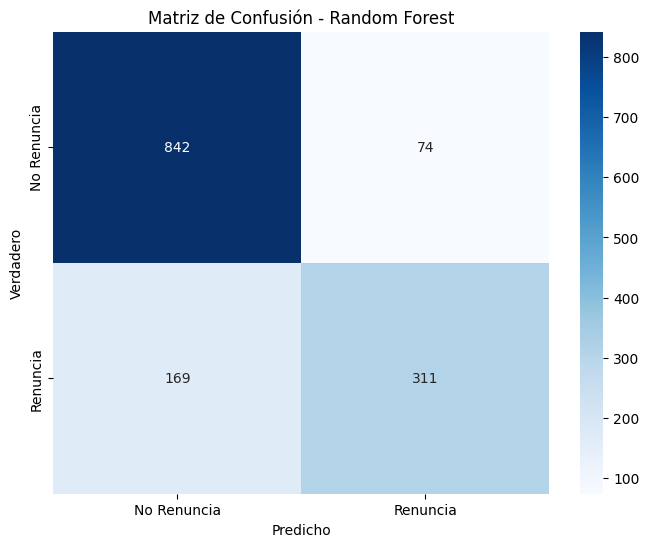

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Renuncia', 'Renuncia'],
            yticklabels=['No Renuncia', 'Renuncia'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()


## 8. IMPORTANCIA DE VARIABLES

### 8.1 Extraer Importancia de Características


In [16]:
# Obtener nombres de características después de OneHotEncoding
feature_names = (rf_pipe.named_steps['prep']
                 .get_feature_names_out())

# Obtener importancia del modelo
importances = rf_pipe.named_steps['model'].feature_importances_

# Crear DataFrame con importancias
imp_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
}).sort_values('Importancia', ascending=False)

print("Top 10 Variables Más Importantes:")
print(imp_df.head(10))

Top 10 Variables Más Importantes:
                          Variable  Importancia
13                     num__Tenure     0.340874
10                        num__Age     0.172086
12                num__PaymentTier     0.093672
11  num__ExperienceInCurrentDomain     0.087599
5                   cat__City_Pune     0.064286
1           cat__Education_Masters     0.045988
6               cat__Gender_Female     0.043037
0         cat__Education_Bachelors     0.039668
7                 cat__Gender_Male     0.037787
3              cat__City_Bangalore     0.025190


### 8.2 Visualizar Importancia de Variables

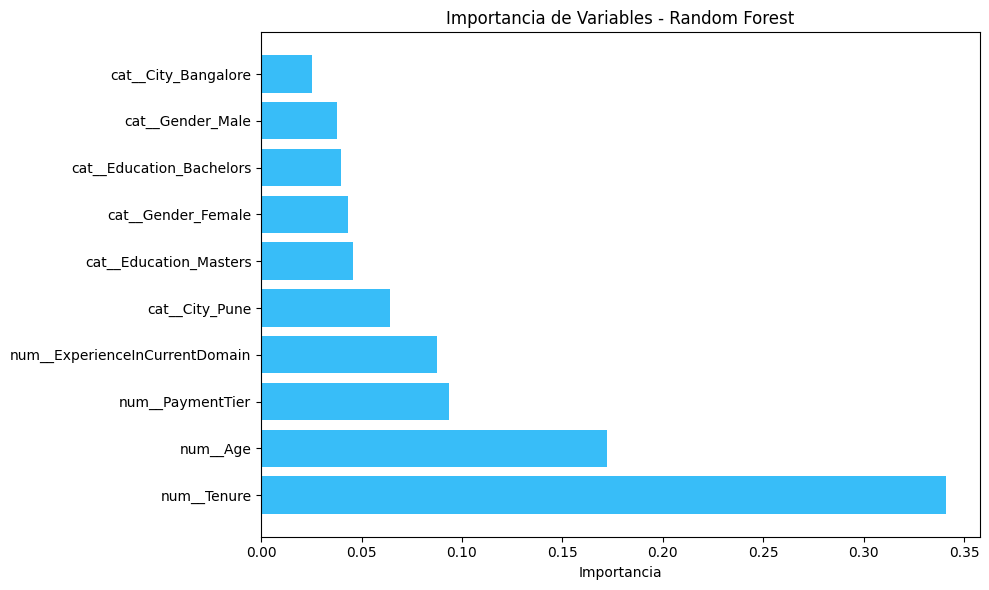

In [17]:
# Gráfico de importancia
plt.figure(figsize=(10, 6))
plt.barh(imp_df['Variable'][:10], imp_df['Importancia'][:10], color='#38bdf8')
plt.title('Importancia de Variables - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()


## 9. AJUSTE DE HIPERPARÁMETROS Y TÉCNICAS AVANZADAS

### 9.1 Modelo con Class Weight (Desbalance)

In [18]:
# Entrenar modelo con class_weight='balanced'
rf_weighted = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, 
                                     class_weight='balanced', 
                                     random_state=42))
])

rf_weighted.fit(X_train, y_train)
y_pred_weighted = rf_weighted.predict(X_test)

print("Recall (Weighted):", recall_score(y_test, y_pred_weighted))
print(classification_report(y_test, y_pred_weighted))

Recall (Weighted): 0.66875
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       916
           1       0.78      0.67      0.72       480

    accuracy                           0.82      1396
   macro avg       0.81      0.78      0.79      1396
weighted avg       0.82      0.82      0.82      1396



## 10. ANÁLISIS DE UMBRALES (THRESHOLD)

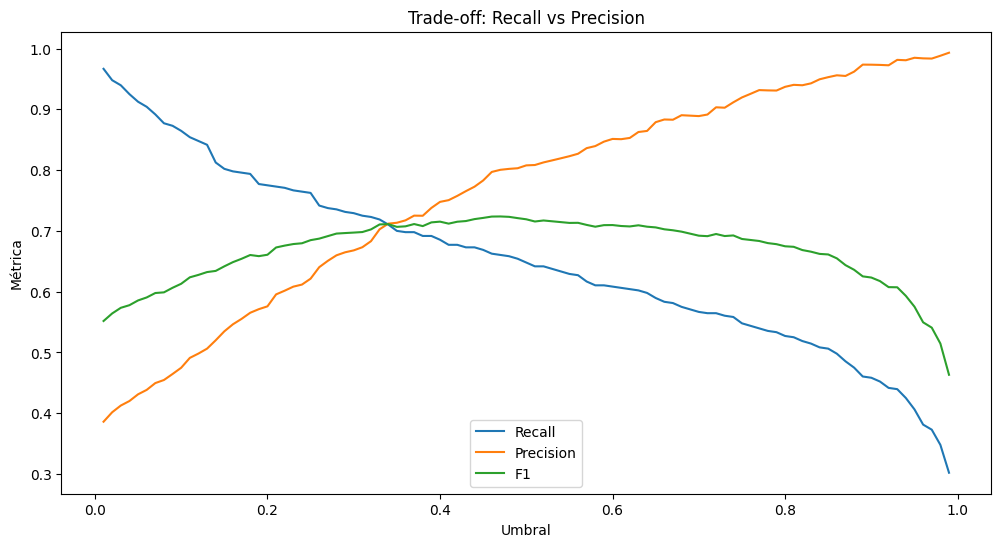

In [27]:
# Probar diferentes umbrales
probabilidades = y_proba  # Probabilidades del modelo
umbrales = np.linspace(0.01, 0.99, 99)
resultados = []

for t in umbrales:
    predicciones = (probabilidades >= t).astype(int)
    resultados.append({
        'umbral': t,
        'recall': recall_score(y_test, predicciones),
        'precision': precision_score(y_test, predicciones, zero_division=0),
        'f1': f1_score(y_test, predicciones, zero_division=0)
    })

resultados_df = pd.DataFrame(resultados)

# Visualizar trade-off
plt.figure(figsize=(12, 6))
plt.plot(resultados_df['umbral'], resultados_df['recall'], label='Recall')
plt.plot(resultados_df['umbral'], resultados_df['precision'], label='Precision')
plt.plot(resultados_df['umbral'], resultados_df['f1'], label='F1')
plt.xlabel('Umbral')
plt.ylabel('Métrica')
plt.legend()
plt.title('Trade-off: Recall vs Precision')
plt.show()

## 11. GUARDADO DE RESULTADOS

In [28]:
# Crear DataFrame con resultados
resultados_finales = X_test.copy()
resultados_finales['Real'] = y_test.values
resultados_finales['Predicho'] = y_pred
resultados_finales['Prob_Renuncia'] = y_proba

# Guardar resultados
resultados_finales.to_csv('resultados_predicciones.csv', index=False)

print("Resultados guardados en 'resultados_predicciones.csv'")

Resultados guardados en 'resultados_predicciones.csv'


## 12. CONCLUSIONES

### Hallazgos Clave:

1. **TENURE (Antigüedad):** Factor más importante (34.5%)
   - Empleados con 0-2 años: 60%+ de renuncia
   - Empleados con 5+ años: 20-30% de renuncia

2. **EDAD:** Segundo factor más importante (17.7%)
   - Empleados jóvenes (20-25): Mayor propensión a renunciar
   - Empleados mayores (40+): Más estables

3. **SALARY TIER (Salario):** Tercer factor (9.6%)
   - Tier 1 (bajo): 50% de renuncia
   - Tier 3 (alto): 30% de renuncia

4. **GÉNERO:** Brecha significativa
   - Mujeres: 45% de renuncia
   - Hombres: 26% de renuncia

5. **CIUDAD:** Variación geográfica
   - Bangalore: 26% (mejor)
   - Pune: 50% (crítico)

### Recomendaciones:

✓ Onboarding reforzado para empleados 0-2 años
✓ Revisión salarial para Tier 1
✓ Auditoría de equidad de género
✓ Investigación urgente en Pune

---

**Autor:** Equipo de Ciencia de Datos  
**Fecha:** 2025-11-21  
**Modelo:** Random Forest (300 árboles)  
**Accuracy:** 83%